# How can homeowners in King County improve the value of their home?

We set out to generate a multiple regression model to predict the effect of different improvements to homes on their sale value using the set of homes sold in 2019 in King County.  We used data from the King County Assessor's [free data catalog](https://www5.kingcounty.gov/sdc/TOC.aspx?subject=property) 

We filtered the data to include only 
1. single family homes 
2. between \\$200,000 and \\$1,500,000
3. that are not designated as 'cabins'

We selected this range of home values because they are affordable to people earning between he median income of the lowest quintile of King County Earners, \\$40,214 dollars, the median income of the highest quintile, \\$250,000, in 2018, according to [Kingcounty.gov](https://www.kingcounty.gov/independent/forecasting/King%20County%20Economic%20Indicators/Household%20Income/KC%20Household%20Income%20Quintiles.aspx) according to [CNN Money's](https://money.cnn.com/calculator/real_estate/home-afford/index.html) home affordabilty calculator.

We also included a statistical test to determine whether converting a home into a duplex might increase the value per square foot.  This would be helpful for homeowners to determine, depending on the size of their home, whether this renovation would be worth the cost.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import imp
imp.reload(data_download)
from src import data_testing
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf # I added this to run regression reports; please remove
# it if you think it is unnecessary. 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
pd.set_option('display.max_columns', None)

## Load data
The data is downloaded with the `get_dataframes()` function.
The `get_tables` function filters the data into the subset we want to study, and divides the features into features represented by continuous or ordinal values, `ordtable` and those that represent different categories of data, `cattable`.

In [3]:
data_dict = data_download.get_dataframes()
ordtable, cattable = data_download.get_tables(data_dict)
for x in cattable.columns:
    cattable[x] = cattable[x].astype('category')

Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
    
Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip
    


C:\Users\caell\new_Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
    


C:\Users\caell\new_Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Lookup.zip
    


In [4]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise,Address
0,560000,0,1,1.0,7,1930,0,0,0,1930,0,0,0,0,550,180,0,0,3,0,0,2,1,0,0,0,1989,0,3,0,10523,0,0,0,0,0,0,0,0,0,0,0,0,0,27033 NE DOROTHY ST 98019
1,435000,0,1,2.0,7,1057,0,0,0,1975,0,0,0,0,465,45,0,0,3,0,2,1,0,1,0,0,1994,0,3,2500,7392,0,0,0,0,0,0,0,0,0,0,0,0,0,22848 SE 264TH CT 98038
2,450000,0,1,1.0,7,1080,0,0,0,1080,0,0,0,0,400,110,0,80,3,0,0,2,1,0,0,0,1986,0,3,0,9940,0,0,0,0,0,0,0,0,0,0,0,0,0,27001 NE MILLER ST 98019
3,380000,0,1,1.5,7,920,0,0,0,1750,920,460,0,6,510,670,0,0,4,1,0,1,0,1,0,1,1963,0,2,0,45303,0,0,0,0,0,0,0,0,0,0,0,0,0,30810 55TH AVE S 98001
4,1025000,0,1,2.0,9,1390,0,0,0,2520,0,0,0,0,510,0,0,800,4,1,0,2,0,1,0,0,1989,0,4,0,17246,0,0,0,0,0,0,0,0,0,0,0,0,0,17619 NE 101ST CT 98052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,930000,100,1,1.0,8,1300,0,0,0,2600,1300,1300,0,7,0,0,0,0,3,0,0,2,0,1,0,1,1948,0,5,0,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,3703 40TH AVE SW 98116
26090,529000,0,1,2.0,8,940,0,0,0,2250,0,0,0,0,730,50,0,100,4,1,0,2,1,0,0,0,2012,0,3,6000,4799,0,0,0,0,0,0,0,0,0,0,0,0,0,23924 SE 284TH PL
26091,805000,0,1,1.0,7,1260,0,0,0,2010,1040,750,0,7,0,60,0,790,3,0,0,2,1,0,0,0,1954,0,2,0,8450,0,0,0,0,0,0,1,0,0,0,0,0,0,11511 EXETER AVE NE 98125
26092,315000,0,1,1.0,6,880,0,0,0,880,0,0,0,0,290,0,0,120,3,0,0,1,0,0,1,0,1968,0,4,0,4400,0,0,0,0,0,0,0,0,0,0,0,0,0,24713 13TH PL S 98198


In [5]:
cattable

,SaleReason,PropertyClass,HeatSystem,HeatSource,PresentUse,HBUAsIfVacant,HBUAsImproved,WaterSystem,SewerSystem,Access,InadequateParking,StreetSurface,Topography,WfntLocation,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,PowerLines,OtherNuisances,AdjacentGolfFairway,AdjacentGreenbelt
0,1,8,5,2,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
1,1,8,5,2,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
2,1,8,1,3,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
3,1,8,4,3,2,1,1,2,1,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
4,1,8,5,2,2,1,1,2,2,4,2,1,1,0,0,0,0,N,N,0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,1,8,4,3,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
26090,1,8,5,2,2,1,1,2,2,3,2,1,0,0,0,0,0,N,N,0,N,N,N,N
26091,1,8,5,1,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
26092,1,8,5,2,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N


## EDA

### Checking the linear correlation of having a porch and sale price

### Comparing the size of the floor plan to the size of the lot and price of the house

In [11]:
# open and closed porch included for chance of any porch being in the floor plan
floor_plan = (ordtable['SqFtGarageAttached'] + ordtable['SqFtDeck'] + ordtable['SqFt1stFloor']
             + (ordtable['SqFtEnclosedPorch'] + ordtable['SqFtOpenPorch'] > 0))

In [12]:
# Created proportion lot variable
lot_proportion = floor_plan / ordtable['SqFtLot']

### Is there a linear correlation between the sales price and the total living space?

This graph of sales show a right skewed distribution with the main number of sales for houses in 2019 between 400,00 and 1,000,000 dollars.

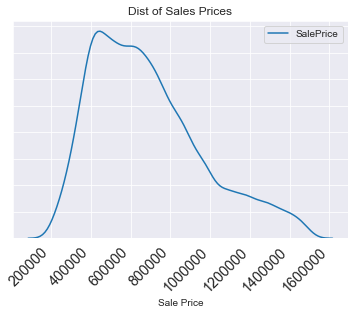

In [10]:
#checked the normality of the distribution of sale prices
sns.set_style('darkgrid')
sales_dist = sns.kdeplot(ordtable['SalePrice'])
plt.title('Dist of Sales Prices')
plt.tick_params(labelleft=False, left=False)
plt.xlabel('Sale Price')
plt.xticks(rotation=45, horizontalalignment='right',fontsize='x-large');

This graph is comparing the total living space to the sale price shows a linear distribution.

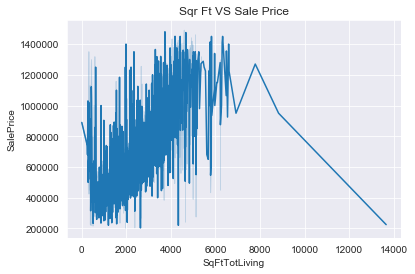

In [11]:

sns.set_style('darkgrid')
sns.lineplot(data=ordtable, x='SqFtTotLiving', y='SalePrice');
plt.title('Sqr Ft VS Sale Price');
plt.savefig('../../reports/figures/SqFt_Vs_Sale_Price')

## Do Duplexes Sell for Less per Square Foot than Single Family Homes?

Let's start by answering this question with a T-Test.

#### Note, this dataset is not the same as for our multiple regression model.  
We have included duplexes in this test which are not present in the data for our regression model, however the price ranges and year sold are the same.

## Hypotheses
Our null hypothesis is that duplexes do not sell for more per square foot than single family homes.
Our alternative hypothesis is that they do sell for more than single family homes.

We will try to get results with a 95% confidence, so we will set our alpha to .95

#### Possible Errors:
If we make a type 1 error, we would claim that duplexes sell for more per square foot, when in reality they do not.

On the other hand, if we make a type 2 error, we would claim that they do not sell for more, when in fact they do.

In [12]:
sales = data_dict['rp_sale']
parcels = data_dict['parcel']
residences = data_dict['res_bldg']

## Filter the data for subset we want to explore


In [13]:
sales = sales[sales['DocumentDate'].astype(str).str.endswith('2019')]
sales = sales[(sales['SalePrice'] > 200000) & (sales['SalePrice'] < 1500000)]

#### Join the tables and extract the features we want to compare

In [14]:
duplexs = parcels[parcels['PresentUse'] == 3]
duplexs = duplexs.merge(sales, on = ['Major','Minor']).merge(residences, on = ['Major','Minor'])
duplexs = duplexs[['SalePrice','SqFtTotLiving']]
duplexs['cost_per_sqft'] = duplexs.SalePrice / duplexs.SqFtTotLiving
singlefamily = parcels[parcels['PresentUse'] == 2]
singlefamily = singlefamily.merge(sales, on = ['Major','Minor']).merge(residences, on = ['Major','Minor'])
singlefamily = singlefamily[['SalePrice','SqFtTotLiving']]
singlefamily['cost_per_sqft'] = singlefamily.SalePrice / singlefamily.SqFtTotLiving

sample1 = duplexs['cost_per_sqft']
sample2 = singlefamily['cost_per_sqft']

### Single family vs duplex: sample size and sample means

In [15]:
print(f'In 2019 {len(sample1)} duplexes were sold, and {len(sample2)} single family homes were sold.')
print(f'The mean cost per sqft of our samples for duplexes is ${round(sample1.mean(), 2)}')
print(f'The mean cost per sqft of our samples for single family homes is ${round(sample2.mean(), 2)}')
print(f'On average, duplexes sell for ${sample1.mean() - sample2.mean()} more per square foot than single family homes')

In 2019 243 duplexes were sold, and 22804 single family homes were sold.
The mean cost per sqft of our samples for duplexes is $384.76
The mean cost per sqft of our samples for single family homes is $348.45
On average, duplexes sell for $36.31515637076092 more per square foot than single family homes


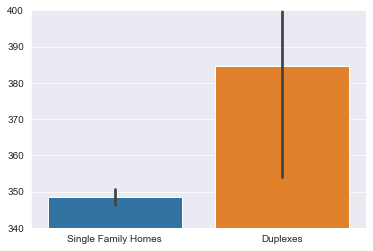

In [16]:
plot = pd.DataFrame({'Single Family Homes':sample2,'Duplexes':sample1})
sns.barplot(data = plot)
plt.ylim(340,400)
plt.savefig(os.path.join(module_path, 'reports/figures/duplex_v_single_family'))

A quick glace at the sample means seems to indicate that, in fact, duplexes sell for about //$36 more per square foot than single family homes. Let's test whether this difference is statistically significant, especially since our sample size of duplexes is much smaller than for single family homes.

## Testing for statistical significance

We will be using a two sample, one-tailed Welch's test to determine the statistical significance of the difference in means.  Our T-critical value tells us that we need a test statistic above 1.645 to confirm with 95% confidence that duplexes sell for more per square foot than single family homes.  We are looking for a pvalue of .05 or less to confirm our result.

In fact, our test returns a test statistic of ~ 2.07 and our p-value is ~ .02.  We can be confident that duplexes sell for more per square foot than single family homes and that the difference is statistically significant

In [17]:
data_testing.tt_ind(sample1, sample2, alpha = .95, equal_var = False, tails = 1)

critical stat is -1.6449197482208529, test stat is 2.1542566435367583 with a pvalue of 0.016099054060786697


### Duplexes sell for about \\$34 per square foot more than single family homes.

![duplex](../../reports/stock_images/zachary-keimig-duplex-unsplash.jpg)

<div align="center">Image by Zachary Keimig</div>

## Multiple regression to find the best ways to improve your home's value

## Model 1:

Choosing the features to include was the most important part of building this model.  Lets try using the ordinal features that directly correlate best with the sale price of the home.

We select the features with the largest direct correlations, positive or negative, with sale price.

#### Set our predictors,`X`, and our target, `y`

In [18]:
ordcorrs = ordtable.corr()['SalePrice'].abs().sort_values(ascending = False).head(20)
bigcorrs = ordtable[list(ordcorrs.index)]
X = bigcorrs.drop(columns = ['SalePrice'])
y = ordtable['SalePrice']

In [19]:
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     1108.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:18:40   Log-Likelihood:            -3.5184e+05
No. Observations:               25761   AIC:                         7.037e+05
Df Residuals:                   25741   BIC:                         7.039e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.853e+06   1.18e+05     41.130      0.000    4.62e+06    5.08e+06
BldgGrade           1.311e+05   2113.543     62.047      0.000    1.27e+05    1.35e+05
SqFtTotLiving        133.3871      4.841     27.555      0.000     123.899     142.875
Stories             3.706e+04   5495.518      6.744      0.000    2.63e+04    4.78e+04
BathFullCount       3.093e+04   3256.916      9.497      0.000    2.45e+04    3.73e+04
Bedrooms           -2.938e+04   1955.369    -15.023      0.000   -3.32e+04   -2.55e+04
SqFt1stFloor         -65.1421      6.529     -9.977      0.000     -77.939     -52.345
SqFtOpenPorch         72.9984     13.187      5.536      0.000      47.151      98.846
SqFtFinBasement      -67.2059      8.392     -8.008      0.000     -83.654     -50.757
SqFtTotBasement       18.0958      5.386      3.359      0.001       7.538      28.654
FinBasementGrade    4674.1378    811.120      5.763      0.000    3084.297    6263.979
Territorial          1.56e+04   2257.417      6.911      0.000    1.12e+04       2e+04
Bath3qtrCount       4.045e+04   3026.651     13.363      0.000    3.45e+04    4.64e+04
SqFtDeck              50.1392      7.184      6.979      0.000      36.058      64.220
FpMultiStory       -5865.6606   3793.164     -1.546      0.122   -1.33e+04    1569.153
BathHalfCount       -1.17e+04   3121.177     -3.749      0.000   -1.78e+04   -5582.237
SqFtGarageAttached   -95.7880      7.080    -13.529      0.000    -109.666     -81.910
Olympics            2.493e+04   4553.474      5.475      0.000     1.6e+04    3.39e+04
YrBuilt            -2719.2607     61.889    -43.938      0.000   -2840.566   -2597.955
FpSingleStory       4921.2029   2948.453      1.669      0.095    -857.930    1.07e+04
==============================================================================
Omnibus:                     1679.518   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3838.120
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                       4.696   Cond. No.                     2.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 1 results
Our model has some predictive power with an R<sup>2</sup> of .452, but suffers from sever multicollinearity with a condition number of almost 30,000.  Let's see if we violate any other linear regression assumptions.

### Assumption Testing

### Homoskedasticity:
Our model is heteroskedastic because the residuals are not randomly distributed when plotted against our predicted sale prices.

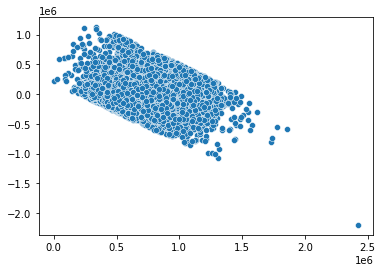

In [17]:
data_testing.homoskedasticity_test(results)

### Linearity

We pass the linear rainbow test for linearity with flying colors by soundly rejecting the null hypothesis of non-linearity. 

#### Linear Rainbow Test:

In [18]:
data_testing.rainbow_stats(results)

{'rainbow_stat': 0.9660856992601355, 'rainbow_p_value': 0.9748300106662768}

### Normality
We violate the normality assumption as well, since our actual sample quantiles do not map neatly to our predicted quantiles. 

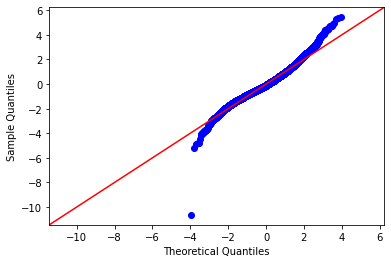

In [19]:
data_testing.normality_graph(results)

### Independence (collinearity)
Our model does also violates the assumption of independance.  The below VIF numbers show how much collinearity each variable introduces into our model. Any score over a 5 is unacceptable.  We have a lot of problematic variables.

In [20]:
data_testing.colinearity_testing(X)

,VIF,feature
0,156.990022,BldgGrade
1,70.255422,SqFtTotLiving
2,48.372268,Stories
3,17.492997,BathFullCount
4,28.477540,Bedrooms
5,42.499421,SqFt1stFloor
6,1.843120,SqFtOpenPorch
7,10.266203,SqFtFinBasement
8,8.220549,SqFtTotBasement
9,7.736599,FinBasementGrade


### Heatmap of collinearity in our variables.

In [ ]:
mask = np.triu(np.ones_like(bigcorrs.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(bigcorrs.corr(), mask= mask, ax = ax, cmap = 'viridis')

We see a lot of collinearity among our variables in high VIF scores above, and by the heatmap just above.  The graph shows the collinearity of our variables, or how they move together.  The bright patches show the intersection of variables that move together in the same direction, while the dark patches show variables that move together, but in opposite directions.  This kind of collinearity degrades the validity of our model.  It would be very hard to disentangle these without sacrificing many variables that are highly correlated to `SalePrice`.  Let's try another approach.

## Model 2: 
SciKitLearn offers many feature selection functions that use iterative algorithms to find the best features for a model.  One such, REFCV chooses both the best features based a recursive feature elimination method, as well as choosing the number of features to include.  Let's try punting on feature selection and letting this algorithm do it for us.

In [20]:
#Scaling the input variables helps the recursive feature elimination algorithm, `RFECV` choose
#features to include in the model.
predictors = ordtable.drop(columns = ['SalePrice','Address']).copy()
pt = StandardScaler()
standardords = pd.DataFrame(pt.fit_transform(predictors))
standardords.columns = predictors.columns

#let RFECV choose from my selected set of features for the final input.  In ensured that
#features relevant to our business questions were included, but that variables that were
#collinear to those features were removed above.
lr = LinearRegression(normalize = False)
select = RFECV(lr)
select = select.fit(X = standardords, y = y)
X = standardords[standardords.columns[list(select.support_)]].reset_index(drop=True)
y = ordtable['SalePrice'].reset_index(drop=True)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [21]:
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     753.0
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:56   Log-Likelihood:            -3.5162e+05
No. Observations:               25761   AIC:                         7.033e+05
Df Residuals:                   25731   BIC:                         7.035e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               6.844e+05   1277.596    535.656      0.000    6.82e+05    6.87e+05
BrickStone          4661.7248   1346.994      3.461      0.001    2021.541    7301.908
Stories             8389.8042   3343.633      2.509      0.012    1836.095    1.49e+04
BldgGrade           1.318e+05   2122.502     62.095      0.000    1.28e+05    1.36e+05
SqFt1stFloor       -3.035e+04   3031.301    -10.012      0.000   -3.63e+04   -2.44e+04
SqFtUpperFloor      9322.8878   1576.477      5.914      0.000    6232.904    1.24e+04
SqFtTotLiving       1.185e+05   4128.635     28.706      0.000     1.1e+05    1.27e+05
SqFtTotBasement     2.589e+04   3460.968      7.480      0.000    1.91e+04    3.27e+04
SqFtFinBasement    -4.621e+04   3886.294    -11.890      0.000   -5.38e+04   -3.86e+04
SqFtGarageBasement -1.669e+04   1948.069     -8.568      0.000   -2.05e+04   -1.29e+04
FinBasementGrade    2.407e+04   2932.577      8.207      0.000    1.83e+04    2.98e+04
SqFtGarageAttached -2.902e+04   1986.281    -14.611      0.000   -3.29e+04   -2.51e+04
SqFtOpenPorch       8359.2193   1463.720      5.711      0.000    5490.246    1.12e+04
SqFtDeck            9115.6877   1425.420      6.395      0.000    6321.784    1.19e+04
Bedrooms           -2.744e+04   1796.786    -15.269      0.000    -3.1e+04   -2.39e+04
BathHalfCount      -3209.3462   1610.987     -1.992      0.046   -6366.972     -51.720
Bath3qtrCount       2.677e+04   1904.849     14.055      0.000     2.3e+04    3.05e+04
BathFullCount       2.356e+04   2214.844     10.635      0.000    1.92e+04    2.79e+04
FpFreestanding     -5971.8597   1323.988     -4.511      0.000   -8566.950   -3376.770
FpAdditional       -7584.7082   1574.336     -4.818      0.000   -1.07e+04   -4498.921
YrBuilt            -7.607e+04   2104.421    -36.150      0.000   -8.02e+04   -7.19e+04
Condition           5951.1200   1457.234      4.084      0.000    3094.860    8807.380
AddnlCost          -1.213e+04   1320.438     -9.185      0.000   -1.47e+04   -9539.978
SqFtLot             3806.5603   1336.578      2.848      0.004    1186.792    6426.329
MtRainier          -7845.1089   1352.409     -5.801      0.000   -1.05e+04   -5194.312
Olympics            8801.5493   1469.490      5.990      0.000    5921.267    1.17e+04
Territorial         4516.5130   1717.443      2.630      0.009    1150.229    7882.797
SeattleSkyline      8897.6529   1322.647      6.727      0.000    6305.191    1.15e+04
LakeWashington      9218.0797   1398.875      6.590      0.000    6476.205     1.2e+04
LakeSammamish       9980.5016   1306.344      7.640      0.000    7419.994    1.25e+04
==============================================================================
Omnibus:                     1732.103   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (J

##### Second model results
Our R<sup>2</sup> score has improved to .459 by letting the algorithm choose features for us.  Our condition number has also dropped down to more acceptable levels.  Let's test other assumptions.

### Assumption Testing

#### Homoskedasticity:
We are still failing this assumption.  Our model is over estimating the value of lower value houses and under estimating the values of higher priced houses.

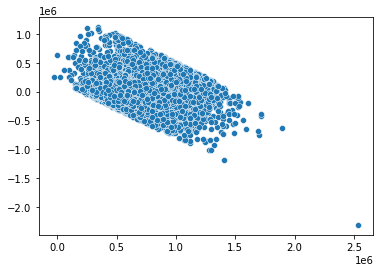

In [23]:
data_testing.homoskedasticity_test(results)

### Linearity

We pass the linear rainbow test for linearity with flying colors by soundly rejecting the null hypothesis of non-linearity. Our model is making linear predictions of the sale price vs the predictors.

#### Linear Rainbow Test:

In [24]:
data_testing.rainbow_stats(results)

{'rainbow_stat': 0.9630909861641467, 'rainbow_p_value': 0.9835306773660563}

### Normality
 Our errors are not normally distributed.

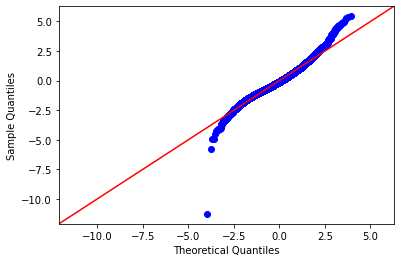

In [25]:
data_testing.normality_graph(results)

### Independence (collinearity)
Our model is doing much better avoiding multi-collinearity, however some variables still have values over 5.  

In [26]:
data_testing.colinearity_testing(X)

,VIF,feature
0,1.111074,BrickStone
1,6.503473,Stories
2,2.746680,BldgGrade
3,5.550244,SqFt1stFloor
4,1.499686,SqFtUpperFloor
5,10.387326,SqFtTotLiving
6,7.324503,SqFtTotBasement
7,9.249784,SqFtFinBasement
8,2.295417,SqFtGarageBasement
9,5.208143,FinBasementGrade


## Model 3:
RFECV did a pretty good job of choosing features with high predictive power and low collinearity.  But, let's see if we can help it along by removing some features from consideration.  We also suspect that some of the categorical variables from cattable may be predictive, so we will let RFECV choose from a select set of those as well.  

In [22]:
#Start building the model input features
predictors = ordtable.drop(columns = ['SalePrice','Address']).copy()

#Set the y target variable
y = ordtable.SalePrice.copy()
y = y.reset_index(drop=True)
#append categorical variables from cattable.
predictors['PropertyClass'] = cattable['PropertyClass']
predictors['InadequateParking'] = cattable['InadequateParking']
predictors['SaleReason'] = cattable['SaleReason']
predictors['WfntLocation'] = cattable['WfntLocation']

#One hot encode categorical variables
predictors = pd.get_dummies(predictors, drop_first = True)

#drop features that have high multicollinearity or cause other problems in our model.
todrop =    ['SqFtLot','SqFt1stFloor','PropertyClass_7',
             'PropertyClass_8','SqFtTotBasement','SqFtFinBasement']
predictors = predictors.drop(columns = todrop)


In [23]:
#Scaling the input variables helps the recursive feature elimination algorithm, `RFECV` choose
#features to include in the model.
pt = StandardScaler()
standardords = pd.DataFrame(pt.fit_transform(predictors))
standardords.columns = predictors.columns

#let RFECV choose from my selected set of features for the final input.  In ensured that
#features relevant to our business questions were included, but that variables that were
#collinear to those features were removed above.
lr = LinearRegression(normalize = False)
select = RFECV(lr)
select = select.fit(X = standardords, y = y)
X = standardords[standardords.columns[list(select.support_)]].reset_index(drop=True)

#`selected_scales` is a subset of the scaling factors from the StandardScaler that match the features
#That RFECV chose for the model.  We use this to unscale the features later for interpretation.
selected_scales = pt.scale_[select.support_]
selected_scales = np.insert(selected_scales,0,1) #add a one for the intercept

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## Feed the selected predictors into the regression model

In [24]:
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     636.9
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:20:34   Log-Likelihood:            -3.5150e+05
No. Observations:               25761   AIC:                         7.031e+05
Df Residuals:                   25725   BIC:                         7.034e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.844e+05   1271.619    538.174      0.000    6.82e+05    6.87e+05
BrickStone           5930.0417   1335.784      4.439      0.000    3311.829    8548.254
Stories              3.532e+04   2133.754     16.555      0.000    3.11e+04    3.95e+04
BldgGrade             1.31e+05   2029.640     64.542      0.000    1.27e+05    1.35e+05
SqFtUpperFloor       4727.3867   1512.034      3.127      0.002    1763.715    7691.059
SqFtTotLiving        8.403e+04   2578.310     32.592      0.000     7.9e+04    8.91e+04
SqFtGarageBasement  -7448.7879   1582.015     -4.708      0.000   -1.05e+04   -4347.949
FinBasementGrade     1.593e+04   1759.032      9.057      0.000    1.25e+04    1.94e+04
SqFtGarageAttached  -2.964e+04   1966.825    -15.071      0.000   -3.35e+04   -2.58e+04
SqFtOpenPorch        1.085e+04   1443.784      7.513      0.000    8017.606    1.37e+04
SqFtDeck             6801.9656   1387.420      4.903      0.000    4082.545    9521.386
Bedrooms            -2.583e+04   1779.344    -14.518      0.000   -2.93e+04   -2.23e+04
BathHalfCount       -4065.2847   1599.272     -2.542      0.011   -7199.947    -930.622
Bath3qtrCount        2.412e+04   1876.701     12.853      0.000    2.04e+04    2.78e+04
BathFullCount         2.22e+04   2198.100     10.099      0.000    1.79e+04    2.65e+04
FpFreestanding      -6768.0271   1307.641     -5.176      0.000   -9331.077   -4204.977
FpAdditional        -7285.6129   1514.084     -4.812      0.000   -1.03e+04   -4317.922
YrBuilt             -8.222e+04   1899.802    -43.279      0.000   -8.59e+04   -7.85e+04
AddnlCost           -1.204e+04   1313.054     -9.166      0.000   -1.46e+04   -9462.042
MtRainier           -7608.3742   1338.789     -5.683      0.000   -1.02e+04   -4984.273
Olympics             7604.4788   1468.375      5.179      0.000    4726.382    1.05e+04
Territorial          4220.9577   1734.566      2.433      0.015     821.111    7620.805
SeattleSkyline       9434.5342   1319.423      7.151      0.000    6848.391     1.2e+04
LakeWashington       7801.1871   1475.492      5.287      0.000    4909.139    1.07e+04
LakeSammamish        9837.4992   1300.980      7.562      0.000    7287.505    1.24e+04
LotDepthFactor      -4097.3668   1546.153     -2.650      0.008   -7127.913   -1066.821
InadequateParking_2  6339.2838   1284.169      4.936      0.000    3822.241    8856.326
SaleReason_4        -1.052e+04   1274.543     -8.251      0.000    -1.3e+04   -8017.659
SaleReason_8        -7217.5640   1275.882     -5.657      0.000   -9718.364   -4716.764
SaleReason_12       -8838.5972   1272.412     -6.946      0.000   -1.13e+04   -6344.598
SaleReason_14       -6043.4805   1277.525     -4.731      0.000   -8547.501   -3539.460
SaleReason_18       -1.802e+04   1276.450    -14.116      0.000   -2.05e+04   -1.55e+04
Sal

## Model 3 Summary:
Model 3 has increased the R<sup>2</sup> score to .464, and has kept the condition number low.  It chose 35 features to include and each one has a low p-value, so a high degree of confidence in the significance of it's influence on the target.  It's the best model yet, and the one we will keep.  Let's check assumptions for validity.

### Assumption Testing

### Homoskedasticity:

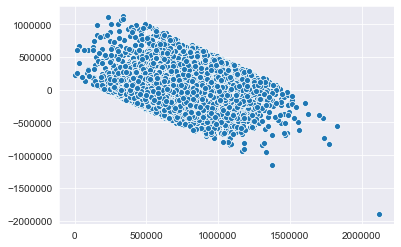

In [25]:
data_testing.homoskedasticity_test(results)

### Linearity

We pass the linear rainbow test for linearity with flying colors by soundly rejecting the null hypothesis of non-linearity. 

#### Linear Rainbow Test:

In [26]:
data_testing.rainbow_stats(results)

{'rainbow_stat': 0.9645071590292349, 'rainbow_p_value': 0.9797781662013716}

### Normality
 

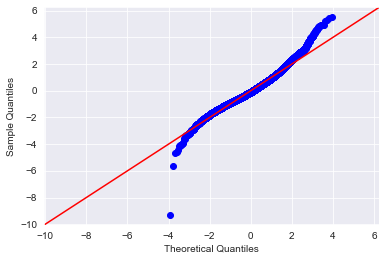

In [27]:
data_testing.normality_graph(results)

### Independence (collinearity)
Our model does not violate the indepedence assumption.
Our above condition score is low, suggesting low multi-collinearity between features. The below variance inflaction test shows that no feature scores above a 5.  This confirms that our features are independent.

In [28]:
data_testing.colinearity_testing(X)

,VIF,feature
0,1.103466,BrickStone
1,2.815624,Stories
2,2.547559,BldgGrade
3,1.413870,SqFtUpperFloor
4,4.111084,SqFtTotLiving
5,1.547774,SqFtGarageBasement
6,1.913522,FinBasementGrade
7,2.392312,SqFtGarageAttached
8,1.289112,SqFtOpenPorch
9,1.190425,SqFtDeck


## The unscaled coefficients

While the coefficients in the model summary represent the scaled features, and show the relative effect of each feature's values, the below coefficients are scaled to the original values of the feature columns.  i.e `BrickStone` represents dollar value per % of home converted to brick or stone and `Square Foot Total Living` represents dollar per square foot.

const                  684352.337099
BrickStone                378.689109
Stories                 64941.159022
BldgGrade              128997.000146
SqFtUpperFloor             50.814602
SqFtTotLiving             100.493030
SqFtGarageBasement        -42.075235
FinBasementGrade         4514.932188
SqFtGarageAttached       -106.902599
SqFtOpenPorch              97.150822
SqFtDeck                   34.357791
Bedrooms               -28034.325646
BathHalfCount           -7872.293977
Bath3qtrCount           38433.855028
BathFullCount           32667.398160
FpFreestanding         -26610.401259
FpAdditional           -19619.872813
YrBuilt                 -2604.492684
AddnlCost                  -5.793231
MtRainier              -33448.785237
Olympics                23982.454523
Territorial              6372.709460
SeattleSkyline          54448.960576
LakeWashington          30950.985318
LakeSammamish           87557.650523
LotDepthFactor          -4516.906501
InadequateParking_2     13123.499243
S

In [37]:
coefficients.index

Index(['const', 'BrickStone', 'Stories', 'BldgGrade', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtGarageBasement', 'FinBasementGrade',
       'SqFtGarageAttached', 'SqFtOpenPorch', 'SqFtDeck', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpFreestanding',
       'FpAdditional', 'YrBuilt', 'AddnlCost', 'MtRainier', 'Olympics',
       'Territorial', 'SeattleSkyline', 'LakeWashington', 'LakeSammamish',
       'LotDepthFactor', 'InadequateParking_2', 'SaleReason_4', 'SaleReason_8',
       'SaleReason_12', 'SaleReason_14', 'SaleReason_18', 'SaleReason_19',
       'WfntLocation_3', 'WfntLocation_5', 'WfntLocation_6'],
      dtype='object')

#### Making sense of the final coefficients.  
The below chart shows interpreted coefficients, in predicted effect on final sale price of changing just that variable.  As you can see, many of these variables are related to location, and thus are not relevant to homeowners who are remodeling their homes.  However, these are included to complete the model and to provide reference.  Notice that the sale reason and proximity to a lake has a large effect on sale price.  While homeowners can do little to change these variables, there is also a lot of value in changing qualities related to the structure itself.  Homeowners can exploit these effects to improve their homes prior to sale.

In [43]:
#Unscale the coefficients so they match expected dollar values for each feature.
coefficients = results.params / selected_scales

coefficients.index = ['Base Home Price', '% Brick and/or Stone', 'Stories', 'Building Grade', 
        'SqFt of Upper Floor', 'SqFt Total Livable Space', 'SqFt Garage Basement', 
        'Finished Basement Grade', 'SqFt Attached Garage', 'SqFt Open Porch', 'SqFt Deck', 'Bedrooms',
       'Half Baths', '3/4 Bath', 'Full Baths', 'Freestanding Fireplaces',
       'Additional Fireplaces', 'Year Built', 'Addional Cost', 'View of Mt. Rainier', 'View of Olympics',
       'Other Views', 'View of Seattle Skyline', 'View of Lake Washington', 'View of Lake Sammamish',
       'Lot Depth Factor', 'Adequate Parking', 'Sale Reason: Foreclosure', 'Sale Reason: Estate Settlement',
       'Sale Reason: Tenancy Partition', 'Sale Reason: Gift', 'Sale Reason: Other', 
       'Sale Reason: Quit Claim Deed', 'Proximity to Puget Sound Waterfront',
        'Proximity to Ship Canal Waterfront', 
        'Proximity to Lake Washington Waterfront']
coefficients = pd.DataFrame(coefficients).reset_index()

coefficients.columns = ['Home Feature','Approximate Value Change']
coefficients

,Home Feature,Approximate Value Change
0,Base Home Price,684352.337099
1,% Brick and/or Stone,378.689109
2,Stories,64941.159022
3,Building Grade,128997.000146
4,SqFt of Upper Floor,50.814602
5,SqFt Total Livable Space,100.493030
6,SqFt Garage Basement,-42.075235
7,Finished Basement Grade,4514.932188
8,SqFt Attached Garage,-106.902599
9,SqFt Open Porch,97.150822


# Summary
We created three models, the first we chose features by how they correlated with sale prices, but we ran into multicollinearity problems.  The second we let the RFECV algorithm choose features for us and it helped us slightly improve our R<sup>2</sup> score and avoid the multicollinearity.  Finally, we used a mixture of manual feature selection and the RFECV algorithm to further improve the model, and ensure our business questions got answered.

The big takeaway was the homeowners should consider:
1. Expanding their homes' size
2. Improving the build quality of their home, including construction materials, fixtures, and architectural design.
3. Building an open porch
4. Adding 3/4 or full baths, especially to the exterior so as to also increase the livable space.
5. Converting larger homes into duplexes to increase the value per square foot.

![View of Seattle](../../reports/stock_images/seattle-view-luca-micheli.jpg)
<div align="center">Image by Luca Micheli</div>